# Random forest and XGBoost model for binary black holes


### IMPORTANT NOTE: 
- This is one the copies of the code run on the full csv file and it excludes in particular two features previously included (GWtime and Temperature)
- In this code, the initial conditions are the ones at the beginning of phase 1 (this code is trying to completly avoid the need for a BSE simulation) 

In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("merged_outputs.csv")

#### READING OUTPUT.CSV FILE
For binary systems the stellar properties are placed before the binary properties. The name of the stellar properties columns have a suffix _0 or _1 for the primary and secondary star, respectively. <br>
The columns in the output csv file are:

0. ID: ID of that binary system (it corresponds to its position in the input file) 
1. Name: unique identifier of the system, randomly drawn at the beginning of the evolution 
2. Mass_0: total mass of the star in Msun
3. MHE_0: mass of the Helium core of the star in Msun
4. MCO_0: mass of the Carbon/Oxigen core of the star in Msun
5. Radius_0: radius of the star in Rsun 
6. RHE_0: radius of Helium core in Rsun         
7. RCO_0: radius of the Carbon/Oxigen core in Rsun          
8. Luminosity_0: luminosity of the star in Lsun   
9. Temperature_0: effective temperature  of the star in Kelvin (temperature of a black body that would emit the same total amount of electromagnetic radiation.
10. Lambda_0: concentration parameter of the stellar envelope in the common envelope model (dimentionless)   
11. Phase_0: SEVN stellar phase (phase of the simulation, number from 1 to 7)       
12. PhaseBSE_0: evolutionary stage of the star in the "bse" code convention (dimentionless)     
13. RemnantType_0: type of the final product of the stellar life (black hole/neutron star/white dwarf) 
14. Zams_0:  zero age main sequence mass (in Msun) of the last selected track (only for internal check)    

(15 - 27) Same properties for the second star 

28. Semimajor: orbital semimajor axis of the binary in Rsun
29. Eccentricity: orbital eccentricity of the binary 
30. GWtime: time in Myr calculated with an approximate general relativity formula         
31. BWolrdtime: time elapsed in the simulations in Myr (starting always from 0)
32. BEvent: string describing the most important processes that happen in the evolution of that specific binary


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11405940 entries, 0 to 11405939
Data columns (total 34 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   ID             int64  
 2   name           object 
 3   Mass_0         float64
 4   MHE_0          float64
 5   MCO_0          float64
 6   Radius_0       float64
 7   RHE_0          float64
 8   RCO_0          float64
 9   Luminosity_0   float64
 10  Temperature_0  float64
 11  Lambda_0       float64
 12  Phase_0        int64  
 13  PhaseBSE_0     float64
 14  RemnantType_0  int64  
 15  Zams_0         float64
 16  Mass_1         float64
 17  MHE_1          float64
 18  MCO_1          float64
 19  Radius_1       float64
 20  RHE_1          float64
 21  RCO_1          float64
 22  Luminosity_1   float64
 23  Temperature_1  float64
 24  Lambda_1       float64
 25  Phase_1        int64  
 26  PhaseBSE_1     float64
 27  RemnantType_1  int64  
 28  Zams_1         float64
 29  Semimajor   

In [4]:
df.describe()

,Unnamed: 0,ID,Mass_0,MHE_0,MCO_0,Radius_0,RHE_0,RCO_0,Luminosity_0,Temperature_0,...,Lambda_1,Phase_1,PhaseBSE_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,GWtime,BWorldtime,BEvent
count,1.140594e+07,1.140594e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,...,3.379834e+06,1.140594e+07,1.140594e+07,1.140594e+07,1.140594e+07,8.929772e+06,8.929772e+06,8.929772e+06,1.140594e+07,1.140594e+07
mean,5.702970e+06,5.001094e+05,9.907307e+00,2.290187e+00,3.901745e-01,5.262284e+01,5.204316e-01,1.044170e-02,9.264498e+04,1.067243e+05,...,7.882656e-01,2.759363e+00,3.757750e+00,6.346868e-03,9.212906e+00,4.975743e+03,1.846735e-01,1.016522e+20,5.352121e+01,1.487364e+00
std,3.292611e+06,2.886388e+05,1.582470e+01,7.719818e+00,3.418105e+00,1.725626e+02,4.864518e+00,5.090469e-02,4.310298e+05,2.989568e+05,...,7.762265e-01,2.278677e+00,4.681663e+00,7.574085e-01,1.139680e+01,7.860896e+04,2.249166e-01,8.116165e+21,8.218948e+01,3.316219e+00
min,0.000000e+00,0.000000e+00,3.122491e-01,0.000000e+00,0.000000e+00,1.278428e-05,0.000000e+00,0.000000e+00,1.000000e-10,5.569800e+02,...,1.257552e-01,1.000000e+00,1.000000e+00,-1.000000e+00,3.600008e-01,2.947162e-02,0.000000e+00,2.331601e-05,0.000000e+00,-1.000000e+00
25%,2.851485e+06,2.501660e+05,1.193223e+00,0.000000e+00,0.000000e+00,7.079578e-03,0.000000e+00,0.000000e+00,9.024713e-02,1.541861e+04,...,5.000000e-01,1.000000e+00,1.000000e+00,0.000000e+00,3.727440e+00,2.309002e+01,7.699887e-03,1.408322e+05,1.028574e+01,0.000000e+00
50%,5.702970e+06,5.001290e+05,5.314675e+00,8.072019e-08,0.000000e+00,3.750035e-01,3.086640e-08,0.000000e+00,2.048564e+03,2.828194e+04,...,5.986290e-01,1.000000e+00,1.000000e+00,0.000000e+00,5.849900e+00,8.595155e+01,9.610000e-02,1.840863e+07,3.026579e+01,0.000000e+00
75%,8.554454e+06,7.500910e+05,1.181128e+01,1.650859e+00,0.000000e+00,9.130722e+00,2.492864e-01,0.000000e+00,2.013534e+04,6.694708e+04,...,9.989920e-01,4.000000e+00,4.000000e+00,0.000000e+00,9.730700e+00,1.297362e+03,2.753994e-01,4.115902e+11,6.352431e+01,3.000000e+00
max,1.140594e+07,9.999990e+05,2.967587e+02,2.166298e+02,1.991020e+02,2.366384e+03,1.367179e+02,1.413096e+00,1.275851e+07,6.756760e+06,...,1.000000e+02,7.000000e+00,1.500000e+01,6.000000e+00,1.490212e+02,1.244851e+08,9.999964e-01,2.230152e+25,8.727068e+02,1.700000e+01


## DATA PREPROCESSING

First of all, we keep only the phase 7 of the simulation, when the two stars have become remnants.
A remnant is the final product of the stellar life: it could be a black hole, a neutron star or a white dwarf. 


In [5]:
print("Even if the number of first star remnant rows:", len(df['Phase_0']==7))
print("Is the same of second star remnant rows:", len(df['Phase_1']==7))
print("The two resulting dataframes wouldn't be equal: pd.equals =", (df['Phase_0']==7).equals(df['Phase_1']==7))
print("Having",len((df['Phase_0']==7).compare(df['Phase_1']==7)), "different rows")

Even if the number of first star remnant rows: 11405940
Is the same of second star remnant rows: 11405940
The two resulting dataframes wouldn't be equal: pd.equals = False
Having 4775604 different rows


So, as expected, we have to impose the condition about phase 7 on both stars.

In [6]:
print('Number of first star remnant rows:', len(df['Phase_0']==7))
print('Number of second star remnant rows:', len(df['Phase_1']==7))
df_7 = df[(df['Phase_0']==7) & (df['Phase_1']==7)]
print('Number of systems in which both stars are now remnants:', len(df_7))

Number of first star remnant rows: 11405940
Number of second star remnant rows: 11405940
Number of systems in which both stars are now remnants: 836441


Then we select the first row of the original dataframe "df" and the last row of the just instantiad dataframe "df_7", creating two different subdataframes. 

In [7]:
new_df_initial = df.groupby('ID').first().reset_index()
new_df_last = df_7.groupby('ID').last().reset_index()
print("Always same number of systems check:")
print(len(new_df_initial))
print(len(df.groupby('ID').last().reset_index()))
print(len(new_df_last))
print("The two new dataframes still have each one of the systems in the same place:")
print(new_df_initial["name"].equals(new_df_last["name"]))
display(new_df_initial.head())
display(new_df_last.head())

Always same number of systems check:
836441
836441
836441
The two new dataframes still have each one of the systems in the same place:
True


,ID,Unnamed: 0,name,Mass_0,MHE_0,MCO_0,Radius_0,RHE_0,RCO_0,Luminosity_0,...,Lambda_1,Phase_1,PhaseBSE_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,GWtime,BWorldtime,BEvent
0,0,6845165,0_631336615655887,7.768624,0.0,0.0,2.594896,0.0,0.0,2826.5860,...,0.595236,1,1.0,0,7.2660,4979.70400,0.3187,7.467008e+13,0.0,-1
1,1,6845178,0_493940794347846,6.264035,0.0,0.0,2.269729,0.0,0.0,1427.5200,...,0.599234,1,1.0,0,4.3761,5203.48300,0.0022,3.768334e+14,0.0,-1
2,2,6845191,0_589731991305321,5.218944,0.0,0.0,2.024327,0.0,0.0,785.1856,...,0.596332,1,1.0,0,5.1078,21.04662,0.0932,1.036472e+05,0.0,-1
3,3,6845206,0_906759387263435,7.545521,0.0,0.0,2.551618,0.0,0.0,2581.1700,...,0.601723,1,1.0,0,3.4388,16584.29000,0.0754,3.900502e+16,0.0,-1
4,5,6845219,0_108022921327766,8.120616,0.0,0.0,2.670201,0.0,0.0,3248.7180,...,0.597496,1,1.0,0,3.0031,37.24250,0.5268,3.408073e+05,0.0,-1


,ID,Unnamed: 0,name,Mass_0,MHE_0,MCO_0,Radius_0,RHE_0,RCO_0,Luminosity_0,...,Lambda_1,Phase_1,PhaseBSE_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,GWtime,BWorldtime,BEvent
0,0,6845177,0_631336615655887,1.270967,0.0,0.0,0.004280,0.0,0.0,0.558986,...,NaN,7,11.0,2,7.673228,23339.33,0.252935,8.645642e+18,40.90071,0
1,1,6845190,0_493940794347846,1.054901,0.0,0.0,0.007175,0.0,0.0,0.049646,...,NaN,7,10.0,1,1.128252,24235.65,0.002059,2.854765e+19,111.54760,0
2,2,6845205,0_589731991305321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7,12.0,3,1.330372,NaN,NaN,NaN,82.76250,0
3,3,6845218,0_906759387263435,1.348688,0.0,0.0,0.002800,0.0,0.0,0.013529,...,NaN,7,11.0,2,3.438800,82349.39,0.097907,3.115592e+21,207.71510,0
4,5,6845234,0_108022921327766,0.920533,0.0,0.0,0.008729,0.0,0.0,0.081625,...,NaN,7,15.0,-1,6.569530,NaN,NaN,NaN,72.11847,8


The "new_df_last" dataframe is useful to create the final "merging/non merging" label that will be appended to the "new_df_initial" dataframe as its new last column. Selecting only the rows with RemnantType_0 and RemnantType_1 both equal to 6 keeps only the binary systems finally composed by two black holes (a binary black hole -BBH-).

In [8]:
new_df_last.loc[ (new_df_last['RemnantType_0'] == 6) & (new_df_last['RemnantType_1'] == 6), 'bbh' ]=1
new_df_last.loc[ (new_df_last['RemnantType_0'] != 6) | (new_df_last['RemnantType_1'] != 6), 'bbh' ]=0

print("Total number of binary systems:", len(new_df_last))
print('Number of binary black holes:', len(new_df_last[new_df_last['bbh']==1]))
print('Number of binary systems of a different kind:', len(new_df_last[new_df_last['bbh']==0]))


Total number of binary systems: 836441
Number of binary black holes: 43617
Number of binary systems of a different kind: 792824


This is the last step to create the label: the "GWtime" column value for that row should be less that the lifetime of the universe in Myr (13700.0 Myr). This means that that BBH is able to merge in due time. <br>
The column values above this threshold and the column values equal to Nan are instead linked to non merging systems: the first ones are too slow, the second ones are not a BBH anymore at the end of the simulation.

In [9]:
new_df_last['mrg/nonmrg'] = 0
new_df_last.loc[ new_df_last['GWtime']  < 13700.0 , 'mrg/nonmrg' ]=1 #merging

print('Number of merging systems:', len(new_df_last[new_df_last['mrg/nonmrg']==1]))
print('Number of non merging systems:', len(new_df_last[new_df_last['mrg/nonmrg']==0]))
print('Number of Nans check:',new_df_last['mrg/nonmrg'].isna().values.sum())

Number of merging systems: 36858
Number of non merging systems: 799583
Number of Nans check: 0


Here we append the "mrg/nonmrg" labels obtained from the "new_df_last" dataframe to the "new_df_initial" dataframe. In this project, we decided to discard all the systems that are not BBH, even if including all the binary systems is one of the first possible future developments.

In [10]:
labels = new_df_last.loc[:,['mrg/nonmrg','bbh']]
final_data = pd.concat([new_df_initial, labels], axis=1)
final_data_bbh = final_data[final_data['bbh']==1]
final_data_bbh.drop(columns="bbh", inplace=True)

Now we have the final dataframe ("final_data_bbh"), the one that we will give to the machine learning algorithms.

In [11]:
final_data_bbh.head(10)

,ID,Unnamed: 0,name,Mass_0,MHE_0,MCO_0,Radius_0,RHE_0,RCO_0,Luminosity_0,...,Phase_1,PhaseBSE_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,GWtime,BWorldtime,BEvent,mrg/nonmrg
17,22,6845396,0_176896908826503,119.23150,0.0,0.0,12.566040,0.0,0.0,1703093.0,...,1,1.0,0,46.7924,54.90501,0.0177,1.469804e+03,0.0,-1,1
94,116,6846397,0_657068005842330,37.26079,0.0,0.0,6.594214,0.0,0.0,193654.6,...,1,1.0,0,18.2395,396.53990,0.0720,9.651152e+07,0.0,-1,0
108,132,6846583,0_550951566446625,33.25268,0.0,0.0,6.215970,0.0,0.0,149194.6,...,1,1.0,0,23.4867,8598.16500,0.3119,1.292550e+13,0.0,-1,0
117,141,6846704,0_770606230539095,91.22868,0.0,0.0,10.786850,0.0,0.0,1104937.0,...,1,1.0,0,42.9523,36.92047,0.0223,5.290812e+02,0.0,-1,1
121,148,6846766,0_663735736747492,30.89447,0.0,0.0,5.942623,0.0,0.0,126127.2,...,1,1.0,0,23.7832,919.97300,0.2312,2.205787e+09,0.0,-1,0
138,166,6846994,0_128178925369444,31.25988,0.0,0.0,5.985497,0.0,0.0,129559.5,...,1,1.0,0,20.4904,503.26950,0.1185,2.761595e+08,0.0,-1,0
140,169,6847026,0_269541901132273,36.05127,0.0,0.0,6.498271,0.0,0.0,179508.1,...,1,1.0,0,31.2844,232.98450,0.2953,4.227822e+06,0.0,-1,0
145,174,6847111,0_267690239111620,80.34259,0.0,0.0,10.236460,0.0,0.0,872657.0,...,1,1.0,0,45.4771,199.10090,0.4432,2.384662e+05,0.0,-1,0
150,179,6847198,0_141004598564401,84.50295,0.0,0.0,10.442410,0.0,0.0,959626.1,...,1,1.0,0,78.0694,73758.13000,0.1857,3.661859e+15,0.0,-1,0
152,181,6847224,0_786680202494961,50.62208,0.0,0.0,7.749824,0.0,0.0,367926.7,...,1,1.0,0,20.1763,142.96720,0.6159,1.631719e+05,0.0,-1,0


In [12]:
final_data_bbh.columns

Index(['ID', 'Unnamed: 0', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0',
       'RHE_0', 'RCO_0', 'Luminosity_0', 'Temperature_0', 'Lambda_0',
       'Phase_0', 'PhaseBSE_0', 'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1',
       'MCO_1', 'Radius_1', 'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1',
       'Lambda_1', 'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1',
       'Semimajor', 'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent',
       'mrg/nonmrg'],
      dtype='object')

## COMMON LAST PREPROCESSING STEPS
We select the significative columns, divide the input data from the labels and split it all in training set (70%) and test set (30%). We also plot a heatmap with the aim to get a glimpse of the eventual direct or inverse correlations between the selected features. 

In [13]:
filtered_data = final_data_bbh.loc[:,['Mass_0','Mass_1','Radius_0','Radius_1', 'Luminosity_0', 
    'Luminosity_1', 'Semimajor', 'Eccentricity', 'mrg/nonmrg']]

<AxesSubplot:>

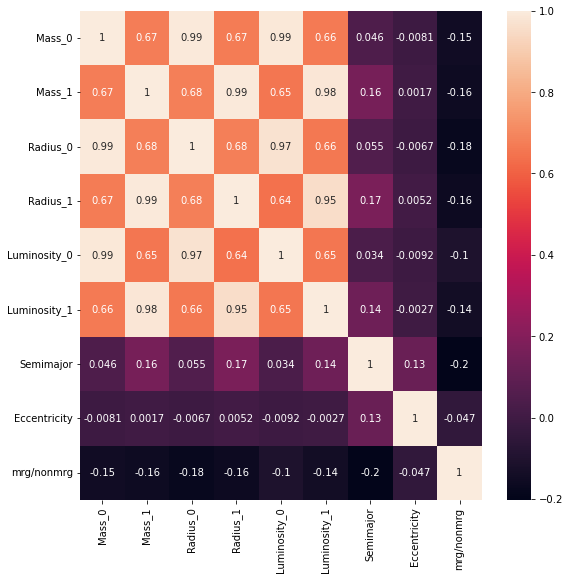

In [14]:
plt.figure(figsize=(9, 9))
sns.heatmap(filtered_data.corr(),annot=True)

In [15]:
print("Number of binary black holes:", len(filtered_data))
print("Number of merging binary black holes:", len(filtered_data[filtered_data['mrg/nonmrg']==1]))
print("Number of non-merging binary black holes:", len(filtered_data[filtered_data['mrg/nonmrg']==0]))

Number of binary black holes: 43617
Number of merging binary black holes: 8151
Number of non-merging binary black holes: 35466


In [16]:
X = filtered_data.iloc[:,:-1]
y = filtered_data.iloc[:,-1:]

In [17]:
X = X.fillna(0)
y = y.fillna(0)

In [18]:
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print("Dimensions check:\ntraining set:", len(X_train),"\ntest set:", len(X_test),"\ntotal:", len(X_train) + len(X_test))

Dimensions check:
training set: 30531 
test set: 13086 
total: 43617


## RANDOM FOREST

Random forest is an ensemble tool which takes a subset of observations and a subset of variables to build a decision trees. Moreover, parameters in random forest are intended either to increase the predictive power of the model or to make it easier to train the model. In order to test different hyperparameters we are emplying GridSearchCV.

GridSearchCV is a library function that is a member of sklearn’s model_selection package: it is a technique to search through the best hyperparameter values from the previously prepared grid of hyperparameters. It is basically a cross-validation method that requires the model and the hyperparameters as arguments and returns the best hyperparameter values. Then the predictions are made with a model trained accordingly. We will be using GridSearchCV not only for the Random forest classifier, but also later for the XGBoost model.

Different parameters for RandomForest MODEL:

- n_estimators: This is the number of trees you want to build before taking the maximum voting or averages of predictions (higher number of trees give you better performance, but makes your code slower)

- max_features: These are the maximum number of features Random Forest is allowed to try in individual tree

- max_depth: The maximum depth of the tree

- criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain.



In [19]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,25],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=3)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.895 total time=   2.1s
[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.895 total time=   2.2s
[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.900 total time=   2.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.887 total time=   1.9s
[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.896 total time=   1.9s
[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.895 total time=   4.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.896 total time=   5.3s
[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.892 total time=   4.5s
[CV 4/5] END criterion=gini, max_depth=5, max_feat

[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.935 total time=  15.8s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.937 total time=  16.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.943 total time=   4.5s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.940 total time=   4.4s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.943 total time=   4.4s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.938 total time=   4.6s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.942 total time=   4.4s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200;, score=0.943 total time=   9.5s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200;, score=0.939 total time=

[CV 3/5] END criterion=gini, max_depth=20, max_features=auto, n_estimators=500;, score=0.952 total time=  19.4s
[CV 4/5] END criterion=gini, max_depth=20, max_features=auto, n_estimators=500;, score=0.949 total time=  19.4s
[CV 5/5] END criterion=gini, max_depth=20, max_features=auto, n_estimators=500;, score=0.951 total time=  19.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.954 total time=   3.7s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.950 total time=   3.8s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.952 total time=   3.7s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.949 total time=   3.7s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.951 total time=   3.7s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200;, score=0.955 total time=

[CV 2/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.954 total time=  25.7s
[CV 3/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.955 total time=  25.7s
[CV 4/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.952 total time=  25.8s
[CV 5/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.955 total time=  27.5s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.888 total time=   3.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.886 total time=   2.5s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.893 total time=   2.6s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.886 total time=   2.6s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.886 t

[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.934 total time=   8.2s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.934 total time=   8.6s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.938 total time=  21.5s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.934 total time=  21.1s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.939 total time=  21.3s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.934 total time=  21.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.934 total time=  21.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.943 total time=   6.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=10

[CV 1/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.956 total time=   9.8s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.951 total time=   9.4s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.955 total time=  10.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.950 total time=   9.7s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.952 total time=   9.8s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=500;, score=0.957 total time=  24.7s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=500;, score=0.951 total time=  24.5s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=500;, score=0.954 total time=  24.1s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=50

[CV 3/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=100;, score=0.954 total time=   6.8s
[CV 4/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=100;, score=0.952 total time=   6.5s
[CV 5/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=100;, score=0.953 total time=   6.3s
[CV 1/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.960 total time=  13.5s
[CV 2/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.954 total time=  12.9s
[CV 3/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.954 total time=  13.3s
[CV 4/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.954 total time=  13.1s
[CV 5/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.955 total time=  13.0s
[CV 1/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=50

{'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'log2',
 'n_estimators': 200}

Using "GridSearchCV.predict" directly will yield the same results as getting the best hyper-parameter through "GridSearchCV.best_param_" and then using it in the random forest classifier

In [20]:
y_pred=CV_rfc.predict(X_test)

The following plot is a feature importance plot: it describes which features are relevant. <br> 
Decision Tree-based methods like random forests and XGBoost models rank the input features in order of importance and take their decisions accordingly during data classification. <br>
It can help granting a better understanding of the problem and sometimes leading to further model developments by improving the feature selection.

<BarContainer object of 8 artists>

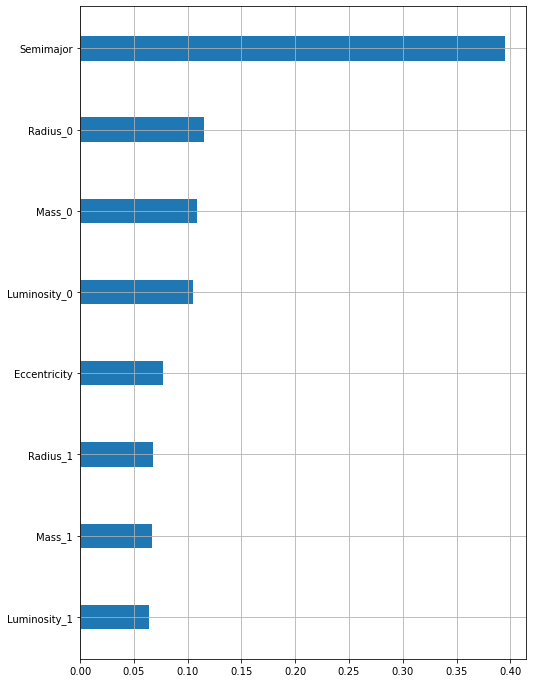

In [21]:
feat_imp_df = pd.DataFrame({"Feature":X.columns, "Importance": CV_rfc.best_estimator_.feature_importances_})
feat_imp_df_desc= feat_imp_df.sort_values("Importance",ascending=True)
plt.figure(figsize=(8, 12))
plt.grid()
plt.barh("Feature","Importance", data=feat_imp_df_desc, height=0.3)

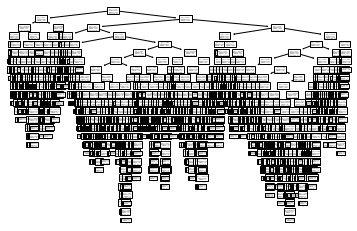

In [22]:
plot_tree(CV_rfc.best_estimator_.estimators_[0])
plt.show()

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9555249885373682


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10600
           1       0.92      0.84      0.88      2486

    accuracy                           0.96     13086
   macro avg       0.94      0.91      0.93     13086
weighted avg       0.95      0.96      0.95     13086



In [25]:
#CONFUSION MATRIX 
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[10406   194]
 [  388  2098]]


## XGBoost MODEL

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. 

First of all, we convert the dataframes X and Y into an optimized data structure called Dmatrix that XGBoost supports, granting best performances (it improves both memory efficiency and training speed).

In [26]:
data_dmatrix = xgb.DMatrix(data=X,label=y) 

Again, we will employ GridSearchCV to loop through predefined hyperparameters and fit our estimator (model) on our training set.

So let's set up a parameter grid that will be explored during the search. <br>
Different parameters for XGBoost model:

- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]

- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.

- max_depth: determines how deeply each tree is allowed to grow during any boosting round.

- n_estimators: number of trees you want to build.

- reg_alpha: L1 regularization term on weights. Increasing this value will make model more conservative


In [27]:
parameters = { 'colsample_bytree': [0.1,0.3,0.5,0.8,1],'learning_rate': [0.01,0.1,0.6,0.8,1], 'max_depth': [1,3,5,8,10], 'reg_alpha':[0] }

In [28]:
estimator = xgb.XGBClassifier(colsample_bytree = 0.8, learning_rate = 1,
                max_depth = 1, reg_alpha=0 , n_estimators = 50)
                # n_estimators = 50 means 50 trees

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[13:18:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max_delta_step=None,
                                     max_depth=1, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=0,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [29]:
#Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods

preds_2 = grid_search.predict(X_test)

In [30]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.6, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Here we plot anothere feature importance plot, this time for XGBoost model.

<Figure size 576x864 with 0 Axes>

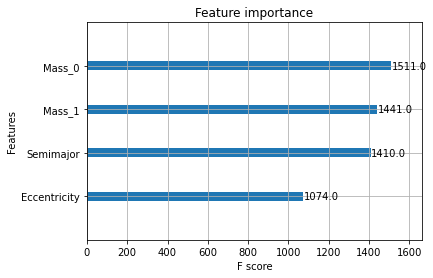

In [31]:
plt.figure(figsize=(8, 12))
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize'] = [8, 12]
plt.show()

In this step we plot individual decision trees from a trained XGBoost gradient boosted model. Running the code creates a plot of the different decision tree in the model, showing the features and feature values for each split as well as the output leaf nodes. Here we plot only a subset of the total trees as an example: the number of trees in equal to the n_estimators parameter (that here is 50).

In [32]:
#fig, tree = plt.subplots(figsize=(30, 30))
xgb_train = xgb.train(params=grid_search.best_params_, dtrain=data_dmatrix, num_boost_round=20)
xgb.plot_tree(xgb_train, num_trees=0)
#plt.rcParams['figure.figsize'] = [200, 200]
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.447417 to fit


In [33]:
xgb.plot_tree(xgb_train, num_trees=1)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.328205 to fit


In [34]:
xgb.plot_tree(xgb_train, num_trees=2)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.327483 to fit


In [35]:
xgb.plot_tree(xgb_train, num_trees=3)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.379195 to fit


In [36]:
print(classification_report(y_test, preds_2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10600
           1       0.90      0.85      0.88      2486

    accuracy                           0.96     13086
   macro avg       0.93      0.92      0.93     13086
weighted avg       0.95      0.96      0.95     13086



In [37]:
#CONFUSION MATRIX 
cf_matrix_2 = confusion_matrix(y_test, preds_2)
print(cf_matrix_2)

[[10373   227]
 [  361  2125]]


## RESULTS COMPARISON
Direct comparison between confusion matrices, accuracies, precisions, recalls and f1 scores from the random forest and from the XGBoost model. <br> 

- Accuracy: Classification accuracy is the total number of correct predictions divided by the total number of predictions made for a dataset.

- Precision: Precision quantifies the number of positive class predictions that actually belong to the positive class, so true positives/(true positives+false positives)

- Recall: Recall quantifies the number of positive class predictions made out of all positive instances in the dataset, so true positive/(true positives+false negatives)

- F-Measure: F-Measure provides a single score that balances both the concerns of precision and recall in one number, precisely 2×precision×recall/(precision + recall)

The following function takes a confusion matrix as an argument and pretty prints all the results mentioned above.

In [38]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(8,8),
                          cmap='Blues',
                          title=None):
   
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [39]:
group_names = ['True Neg','False Pos','False Neg', 'True Pos']
categories = ['Zero', 'One']

Pretty printing of the results for the random forest:

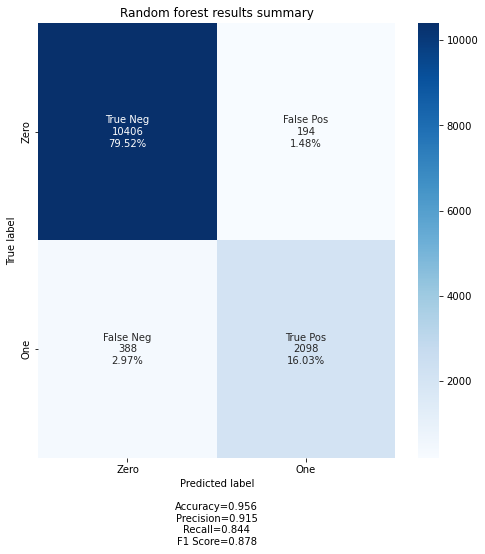

In [40]:
make_confusion_matrix(cf_matrix,
                      group_names=group_names,
                      categories=categories, 
                      cmap='Blues',
                      title="Random forest results summary")

Pretty printing of the results for the XGBoost model:

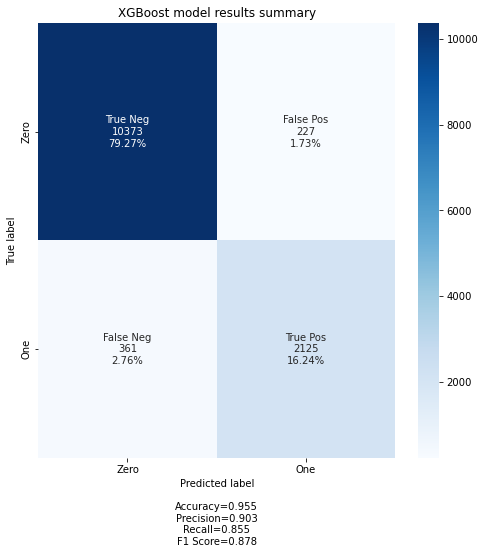

In [41]:
make_confusion_matrix(cf_matrix_2,
                      group_names=group_names,
                      categories=categories, 
                      cmap='Blues',
                      title="XGBoost model results summary")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e6d886b-e60a-4c5b-ad77-020e7f429015' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>